In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-rc1
sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
matplotlib 2.1.0
numpy 1.18.0
pandas 0.20.3
sklearn 0.21.3
tensorflow 2.0.0-rc1
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

AttributeError: head

In [3]:
from sklearn.model_selection import train_test_split
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(11610, 8) (11610,)
(5160, 8) (5160,)
(3870, 8) (3870,)


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_valid_scaler = scaler.transform(x_valid)
x_test_scaler = scaler.transform(x_test)


In [6]:
def build_model(hidden_layers = 1, layer_size = 30, learning_rate = 3e-3):
    model = keras.Sequential()
    model.add(keras.layers.Dense(layer_size, activation = 'relu', input_shape = x_train_scaler.shape[1:]))
    for _ in range(hidden_layers -1):
        model.add(keras.layers.Dense(layer_size,activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    model.summary()
    return model
# step 1:转化模型：如果定义的是回归模型，就用KerasRegressor；分类模型用KerasClassifier     
sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-2)]    
history = sklearn_model.fit(x_train_scaler, y_train, 
                    validation_data = (x_valid_scaler, y_valid),
                    epochs = 10,
                    callbacks = callbacks)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 66us/sample - loss: 1.3377 - val_loss: 0.7074
Epoch 2/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.6130 - val_loss: 0.6184
Epoch 3/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5481 - val_loss: 0.5715
Epoch 4/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5147 - val_loss: 0.5367
Epoch 5/10
11610/11610 [===================

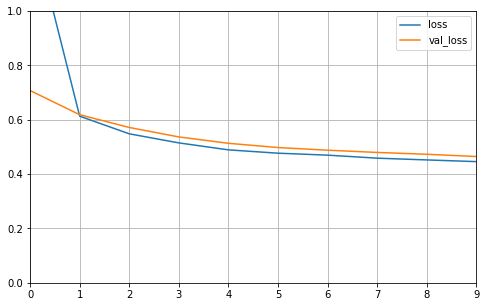

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [9]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a<=x<=b

param_distribution = {
    'hidden_layers': [1, 2, 3, 4],
    'layer_size': np.arange(1, 100),
    'learning_rate': reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV
random_search_cv = RandomizedSearchCV(sklearn_model,
                                     param_distribution,
                                     n_iter = 10,
                                     cv =3,
                                     n_jobs = 1)
random_search_cv.fit(x_train_scaler, y_train, epochs = 100,
                    validation_data = (x_valid_scaler, y_valid),
                    callbacks = callbacks)
# cross_validation: 训练集分成n份,n-1 用于训练，最后一份用于验证

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 62)                558       
_________________________________________________________________
dense_3 (Dense)              (None, 62)                3906      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 63        
Total params: 4,527
Trainable params: 4,527
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 63us/sample - loss: 3.3955 - val_loss: 1.7714
Epoch 2/100
7740/7740 [==============================] - 0s 36us/sample - loss: 1.3491 - val_loss: 1.1223
Epoch 3/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.9666 - val_loss: 0.9216
Epoch 4/100
7740

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 62)                558       
_________________________________________________________________
dense_6 (Dense)              (None, 62)                3906      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 63        
Total params: 4,527
Trainable params: 4,527
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 76us/sample - loss: 2.6591 - val_loss: 1.4980
Epoch 2/100
7740/7740 [==============================] - 0s 36us/sample - loss: 1.1284 - val_loss: 1.0409
Epoch 3/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.8563 - val_loss: 0.8777
Epoch 4/100
7740

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 62)                558       
_________________________________________________________________
dense_9 (Dense)              (None, 62)                3906      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 63        
Total params: 4,527
Trainable params: 4,527
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 64us/sample - loss: 3.1543 - val_loss: 1.9244
Epoch 2/100
7740/7740 [==============================] - 0s 36us/sample - loss: 1.3421 - val_loss: 1.1781
Epoch 3/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.9136 - val_loss: 0.9185
Epoch 4/100
7740

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 70)                630       
_________________________________________________________________
dense_12 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_13 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_14 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 71        
Total params: 15,611
Trainable params: 15,611
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 86us/sam

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 70)                630       
_________________________________________________________________
dense_17 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_18 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_19 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 71        
Total params: 15,611
Trainable params: 15,611
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 73us/sam

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 70)                630       
_________________________________________________________________
dense_22 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_23 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_24 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 71        
Total params: 15,611
Trainable params: 15,611
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 88us/sam

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 38)                342       
_________________________________________________________________
dense_27 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_28 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 39        
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.9337 - val_loss: 0.5981
Epoch 2/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5774 - val_los

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 38)                342       
_________________________________________________________________
dense_31 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_32 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 39        
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 67us/sample - loss: 1.2450 - val_loss: 0.6632
Epoch 2/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5721 - val_los

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 38)                342       
_________________________________________________________________
dense_35 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_36 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 39        
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.8738 - val_loss: 0.6601
Epoch 2/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5437 - val_los

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 86)                774       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 87        
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 75us/sample - loss: 4.6806 - val_loss: 4.2077
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 3.4584 - val_loss: 3.1789
Epoch 3/100
7740/7740 [==============================] - 0s 34us/sample - loss: 2.6487 - val_loss: 2.4849
Epoch 4/100
7740/7740 [==============================] - 0s 34us/sample - loss: 2.1008 - val_loss: 2.0125
Epoch 5/100
7740/7740 [======================

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 86)                774       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 87        
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 59us/sample - loss: 4.3296 - val_loss: 3.8880
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 3.3082 - val_loss: 3.0162
Epoch 3/100
7740/7740 [==============================] - 0s 34us/sample - loss: 2.6114 - val_loss: 2.4207
Epoch 4/100
7740/7740 [==============================] - 0s 34us/sample - loss: 2.1239 - val_loss: 2.0011
Epoch 5/100
7740/7740 [======================

3870/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 86)                774       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 87        
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 59us/sample - loss: 4.0013 - val_loss: 3.6938
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 3.1206 - val_loss: 2.9337
Epoch 3/100
7740/7740 [==============================] - 0s 34us/sample - loss: 2.4981 - val_loss: 2.3922
Epoch 4/100
7740/7740 [==============================] - 0s 35us/sample - loss: 2.0487 - val_loss: 1.9965
Epoch 5/100
7740/7740 [======================

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 73)                657       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 74        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 74us/sample - loss: 2.2126 - val_loss: 1.1480
Epoch 2/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.8877 - val_loss: 0.8246
Epoch 3/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7274 - val_loss: 0.7518
Epoch 4/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6835 - val_loss: 0.7167
Epoch 5/100
7740/7740 [======================

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 73)                657       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 74        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 58us/sample - loss: 2.2154 - val_loss: 1.1095
Epoch 2/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.8914 - val_loss: 0.8760
Epoch 3/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7724 - val_loss: 0.8091
Epoch 4/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7240 - val_loss: 0.7667
Epoch 5/100
7740/7740 [======================

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 73)                657       
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 74        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 58us/sample - loss: 2.7992 - val_loss: 1.2669
Epoch 2/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.9077 - val_loss: 0.8182
Epoch 3/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7150 - val_loss: 0.7531
Epoch 4/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6689 - val_loss: 0.7237
Epoch 5/100
7740/7740 [======================

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 51)                459       
_________________________________________________________________
dense_51 (Dense)             (None, 51)                2652      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 52        
Total params: 3,163
Trainable params: 3,163
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 62us/sample - loss: 3.7004 - val_loss: 1.9007
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.3014 - val_loss: 1.0645
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.9201 - val_loss: 0.8964
Epoch 4/100
774

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 51)                459       
_________________________________________________________________
dense_54 (Dense)             (None, 51)                2652      
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 52        
Total params: 3,163
Trainable params: 3,163
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 62us/sample - loss: 2.8132 - val_loss: 1.6317
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.2317 - val_loss: 1.0135
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8591 - val_loss: 0.8465
Epoch 4/100
774

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 51)                459       
_________________________________________________________________
dense_57 (Dense)             (None, 51)                2652      
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 52        
Total params: 3,163
Trainable params: 3,163
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 62us/sample - loss: 2.2823 - val_loss: 1.4660
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.0853 - val_loss: 1.0079
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8602 - val_loss: 0.8857
Epoch 4/100
774

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 56)                504       
_________________________________________________________________
dense_60 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 57        
Total params: 3,753
Trainable params: 3,753
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 62us/sample - loss: 2.4349 - val_loss: 1.3762
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.0662 - val_loss: 0.9439
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8428 - val_loss: 0.8396
Epoch 4/100
774

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 56)                504       
_________________________________________________________________
dense_63 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 57        
Total params: 3,753
Trainable params: 3,753
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 62us/sample - loss: 2.8655 - val_loss: 1.4348
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.0396 - val_loss: 0.9431
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.7935 - val_loss: 0.7960
Epoch 4/100
774

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 56)                504       
_________________________________________________________________
dense_66 (Dense)             (None, 56)                3192      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 57        
Total params: 3,753
Trainable params: 3,753
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 63us/sample - loss: 2.9382 - val_loss: 1.8529
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.2633 - val_loss: 1.0943
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8371 - val_loss: 0.8398
Epoch 4/100
774

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 83)                747       
_________________________________________________________________
dense_69 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_70 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_71 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 84        
Total params: 21,747
Trainable params: 21,747
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 73us/sa

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 83)                747       
_________________________________________________________________
dense_74 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_75 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_76 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 84        
Total params: 21,747
Trainable params: 21,747
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 73us/sa

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 83)                747       
_________________________________________________________________
dense_79 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_80 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_81 (Dense)             (None, 83)                6972      
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 84        
Total params: 21,747
Trainable params: 21,747
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 93us/sa

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 39)                351       
_________________________________________________________________
dense_84 (Dense)             (None, 39)                1560      
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 40        
Total params: 1,951
Trainable params: 1,951
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 62us/sample - loss: 2.3963 - val_loss: 1.1114
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8797 - val_loss: 0.8727
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.7716 - val_loss: 0.8076
Epoch 4/100
774

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 39)                351       
_________________________________________________________________
dense_87 (Dense)             (None, 39)                1560      
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 40        
Total params: 1,951
Trainable params: 1,951
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 61us/sample - loss: 2.2882 - val_loss: 1.3475
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.1280 - val_loss: 0.9259
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.7679 - val_loss: 0.8140
Epoch 4/100
774

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 39)                351       
_________________________________________________________________
dense_90 (Dense)             (None, 39)                1560      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 40        
Total params: 1,951
Trainable params: 1,951
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 62us/sample - loss: 2.7433 - val_loss: 1.3654
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.9464 - val_loss: 0.8495
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.7136 - val_loss: 0.7626
Epoch 4/100
774

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 59)                531       
_________________________________________________________________
dense_93 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_94 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 60        
Total params: 7,671
Trainable params: 7,671
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 88us/sample - loss: 1.0529 - val_loss: 0.6640
Epoch 2/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5921 - val_lo

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 59)                531       
_________________________________________________________________
dense_97 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_98 (Dense)             (None, 59)                3540      
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 60        
Total params: 7,671
Trainable params: 7,671
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 66us/sample - loss: 1.2009 - val_loss: 0.6410
Epoch 2/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5593 - val_lo

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 59)                531       
_________________________________________________________________
dense_101 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_102 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 60        
Total params: 7,671
Trainable params: 7,671
Non-trainable params: 0
_________________________________________________________________
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 66us/sample - loss: 1.0547 - val_loss: 0.6654
Epoch 2/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5440 - val_lo

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 38)                342       
_________________________________________________________________
dense_105 (Dense)            (None, 38)                1482      
_________________________________________________________________
dense_106 (Dense)            (None, 38)                1482      
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 39        
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________
Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.9894 - val_loss: 0.6034
Epoch 2/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5094 - v

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7ffafe340f60>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37,...46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffaf449f710>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_

In [10]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 2, 'layer_size': 38, 'learning_rate': 0.005559526306944552}
-0.35922089255030665


In [8]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaler, y_test)


NameError: name 'random_search_cv' is not defined